In [30]:
import os
import numpy as np
import scipy.misc as msc
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import plotly.plotly as py
import plotly.graph_objs as go

In [65]:
def draw(vector, shape):
    plt.figure()
    plt.imshow(np.reshape(vector, shape), 'gray')
    plt.axis('off')
    plt.show()

def save_image(vector, shape, name):
    plt.figure()
    plt.imshow(np.reshape(vector, shape), 'gray')
    plt.axis('off')
    plt.savefig('img/' + name, bbox_inches='tight')
    
def read_names(folder):
    files = os.listdir(folder)
    return files

def read_images(folder, names):
    images = [msc.imread(folder + '/' + f) for f in names]
    # for index, image in enumerate(images):
        #if image.shape != (31, 81):
        #    print names[index]
        # print image.shape

    return images
    
def flatten(images):
    X = np.stack(images, axis=0)
    shape = X.shape[1:]
    X = [image.flatten() for image in X]
    return X, shape

def center(images):
    mean = np.mean(images, axis=0)
    print 'as array shape', np.asarray(images).shape
    return (images - mean) / np.std(np.asarray(image)), mean

def to_dict(tuple):
    return dict([('image', tuple[0]), ('label', tuple[1])])

def positive(name):
    return 'Pos' in name

def negative(name):
    return 'Neg' in name

def label(names, index):
    return 1 if positive(names[index]) else -1

def normilize(img, shape):
    new_img = Image.fromarray(np.uint8(img))
    new_img = new_img.resize(shape[::-1])
    return np.asarray(new_img)

def vector2matrix(vector, shape):
    return np.reshape(vector, shape)

def matrix2vector(matrix):
    shape = matrix.shape
    return matrix.flatten(), shape


In [47]:
train_folder = '../uiucTrain'
train_names = read_names(train_folder)

In [48]:
train_images = read_images(train_folder, train_names)
train_images, shape = flatten(train_images)
train_images = [to_dict((image, label(train_names, index))) \
                for index, image in enumerate(train_images)]


In [49]:
def center_sets(images):
    pos = [image['image'] for image in images \
           if image['label'] == 1]
    
    centered_pos, mean_pos = center(pos)
    
    neg = [image['image'] for image in images \
           if image['label'] == -1]
    
    centered_neg, mean_neg = center(neg)
    
    full, mean = center([image['image'] for image in images])
    
    return centered_pos, centered_neg, mean_pos, mean_neg, full, mean

pos, neg, mean_pos, mean_neg, full, mean = center_sets(train_images)

# draw(mean_pos, (31, 81))
# draw(pos[])
# print pos.mean(axis=0)


# images = [to_dict((image, label(train_names, index))) \
#                for index, image in enumerate(full)]

# pos = [image['image'] for image in images \
#           if image['label'] == 1]

#neg = [image['image'] for image in images \
#           if image['label'] == -1]


as array shape (124, 2511)
as array shape (2442, 2511)
as array shape (2566, 2511)


In [50]:
car_number = 12
first_car = 2442

# draw(mean_neg, shape)
# draw(mean_pos, shape)

In [51]:
size = shape[0] * shape[1]
S_pos = np.zeros((size, size))
for v in pos:
    v1 = v.reshape((size, 1))
    v2 = v.reshape((1, size))
    S_pos += np.dot(v1, v2)
    
S_neg = np.zeros((size, size))
for v in neg:
    v1 = v.reshape((size, 1))
    v2 = v.reshape((1, size))
    S_neg += np.dot(v1, v2)

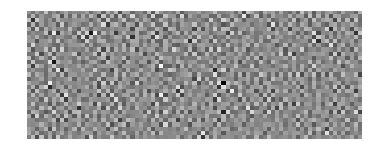

-0.547391209325
0.452608790675
206.974374891


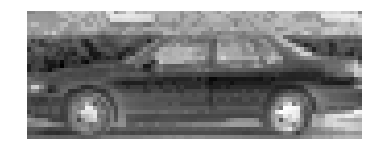

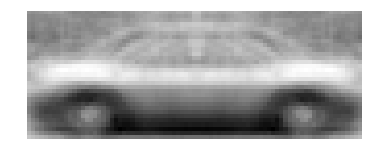

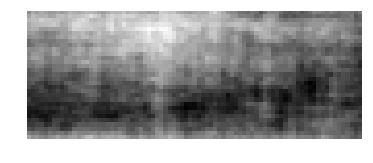

In [58]:
# draw(S_pos, (size, size))
# draw(S_neg, (size, size))
Sw = S_neg + S_pos
# Sw = Sw.T
# Sw, S_neg, S_pos, Sw_inv

# draw(Sw, (size, size))
Sw_inv = np.linalg.inv(Sw)
# Sw_inv = Sw_inv.T
# draw(Sw_inv, (size, size))
w = np.dot(Sw_inv, mean_pos - mean_neg) # мб neg - pos
draw(w, shape)
print min(w) / (max(w) - min(w))
print max(w) / (max(w) - min(w))
print max(w) - min(w)

draw(pos[0], shape)
draw(mean_pos, shape)
draw(mean_neg, shape)

In [53]:
mu_pos = 0
for v in pos:
    mu_pos += np.dot(w, v)
# mu_pos /= len(pos)
mu_pos = np.dot(w, mean_pos) / len(pos)

mu_neg = 0
for v in neg:
    mu_neg += np.dot(w, v)
# mu_neg /= len(neg)
mu_neg = np.dot(w, mean_neg) / len(neg)
print mu_pos
print mu_neg

110.077778718
-0.182352535476


In [54]:
test_folder = '../uiucTest'
test_names = read_names(test_folder)

In [68]:
test_images = read_images(test_folder, test_names)
normed = []
for img in test_images:
    normed.append(normilize(img, shape))
    
test_images = normed
test_images, shape = flatten(test_images)
test_images = [to_dict((image, label(test_names, index))) \
                for index, image in enumerate(test_images)]


In [69]:
classifiers = []
def classifier(mu1, mu2, index, total, w):
    tetta = mu1 + abs(float(mu2 - mu1)) / (total + 1) * (index + 1)
    def cl(x):
        if np.dot(w, x) >= tetta:
            return 1
        return -1
    return cl

cl_number = 10
for index in range(cl_number):
    classifiers.append(classifier(mu_neg, mu_pos, index, cl_number, w))

In [70]:
pr = []
rec = []
for cl in classifiers:
    true_pos = 0
    false_neg = 0
    for im in pos:
        if cl(im) != 1:
            false_neg += 1
        else:
            true_pos += 1
    
    true_neg = 0
    false_pos = 0
    for im in neg:
        if cl(im) != -1:
            false_pos += 1
        else:
            true_neg += 1
    # print float(errors_pos) / len(pos), float(errors_neg) / len(neg), float(errors_pos + errors_neg)/(len(neg) + len(pos))
    pr.append(float(true_pos) / (true_pos + false_pos))
    rec.append(float(true_pos) / (true_pos + false_neg))
    
n_groups = cl_number
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, pr, bar_width,
                 alpha=opacity,
                 color='b',
                 label='pr')
 
rects2 = plt.bar(index + bar_width, rec, bar_width,
                 alpha=opacity,
                 color='g',
                 label='rec')
 
plt.xlabel('r')
plt.ylabel('')
plt.title('')
plt.xticks(index + bar_width, range(cl_number))
plt.legend()
 
plt.tight_layout()
plt.show()

ZeroDivisionError: float division by zero

In [14]:
test_images = read_images(test_folder, test_names)
test_images = [normilize(img, shape) for img in test_images]
test_images, _ = flatten(test_images)
total_test = len(test_images)
for cl in classifiers:
    correct = 0
    for img in test_images:
        if cl(img) == 1:
            correct += 1
    print float(correct) / total_test

# img = img[:, :, 0]
# draw(img, img.shape)
# new_img = normilize(img, shape)
# draw(new_img, new_img.shape)


0.505882352941
0.505882352941
0.505882352941
0.505882352941
0.505882352941
0.505882352941
0.505882352941
0.505882352941
0.505882352941
0.505882352941


In [15]:
test_images[9].shape

(2511,)

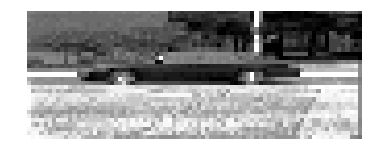

In [16]:
draw(test_images[4], shape)